<a href="https://colab.research.google.com/github/Debajyoti2004/GANs-Paper-implementations/blob/main/Deep_Convolutional_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

In [2]:
class Discriminator(nn.Module):
  def __init__(self,channels_img,features_d):
    super(Discriminator,self).__init__()
    # Input: N * channels_img * 64 * 64
    self.disc = nn.Sequential(
        nn.Conv2d(
            channels_img,
            features_d,
            kernel_size=4,
            stride=2,
            padding=1,
        ), # 32*32
        nn.LeakyReLU(0.2),
        self._block(features_d,features_d*2,4,2,1),#16*16
        self._block(features_d*2,features_d*4,4,2,1),#8*8
        self._block(features_d*4,features_d*8,4,2,1),#4*4
        nn.Conv2d(
            features_d*8,
            1,
            kernel_size=4,
            stride=2,
            padding=0
        ),
        nn.Sigmoid()#1*1
    )

  def _block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
        )

  def forward(self,x):
      return self.disc(x)


In [3]:
class Generator(nn.Module):
  def __init__(self,z_dim,channels_img,features_g):
    super(Generator,self).__init__()
    self.gen = nn.Sequential(
        self._block(z_dim,features_g*16,4,1,0), # N x f_g*16 x 4 x 4
        self._block(features_g*16,features_g*8,4,2,1), # 8x8
        self._block(features_g*8,features_g*4,4,2,1), # 16x16
        self._block(features_g*4,features_g*2,4,2,1),
        nn.ConvTranspose2d(
            features_g*2,
            channels_img,
            kernel_size=4,
            stride=2,
            padding=1,
        ),
        nn.Tanh(), #[-1,1] 64*64
    )


  def _block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self,x):
    return self.gen(x)



In [4]:
 def initialize_weights(model):
    for m in model.modules():
      if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data,0.0,0.02)

In [5]:
def test():
  N,in_channels,H,W = 8,3,64,64
  z_dim = 100
  x = torch.randn((N,in_channels,H,W))
  disc = Discriminator(in_channels,8)
  initialize_weights(disc)
  assert disc(x).shape == (N,1,1,1)
  print(f"output shape from disc:{disc(x).shape}")
  gen = Generator(z_dim,in_channels,8)
  initialize_weights(gen)
  z = torch.randn((N,z_dim,1,1))
  assert gen(z).shape == (N,in_channels,H,W)
  print(f"output shape from gen:{gen(z).shape}") # Changed x to z
  print("Success")

In [6]:
test()

output shape from disc:torch.Size([8, 1, 1, 1])
output shape from gen:torch.Size([8, 3, 64, 64])
Success


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

In [8]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


In [10]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)


In [11]:
datasets = datasets.MNIST(root="dataset/",train=True,transform=transforms,download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.32MB/s]


In [12]:
import torch.optim as optim


In [13]:
loader = DataLoader(datasets,batch_size=BATCH_SIZE,shuffle=True)
gen = Generator(Z_DIM,CHANNELS_IMG,FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG,FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
opt_disc = optim.Adam(disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(32,Z_DIM,1,1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [19]:
import matplotlib.pyplot as plt
import torchvision

def plot_images(real, fake, num_images=8):
    """
    Function to plot real and fake images side by side.
    Args:
    - real: real image batch (tensor)
    - fake: fake image batch (tensor)
    - num_images: number of images to display per batch (default 8)
    """
    # Take first `num_images` from the batch for visualization
    real_batch = real[:num_images]
    fake_batch = fake[:num_images]

    # Normalize images to [0, 1]
    real_batch = (real_batch + 1) / 2
    fake_batch = (fake_batch + 1) / 2

    # Create grids of images
    real_grid = torchvision.utils.make_grid(real_batch, nrow=num_images)
    fake_grid = torchvision.utils.make_grid(fake_batch, nrow=num_images)

    # Convert to numpy arrays for display
    real_np = real_grid.permute(1, 2, 0).cpu().numpy()
    fake_np = fake_grid.permute(1, 2, 0).cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(real_np)
    axes[0].set_title("Real Images")
    axes[0].axis("off")

    axes[1].imshow(fake_np)
    axes[1].set_title("Fake Images")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


Epoch [0/5] Batch 0/469 Loss D: 0.4688, Loss G: 1.2313


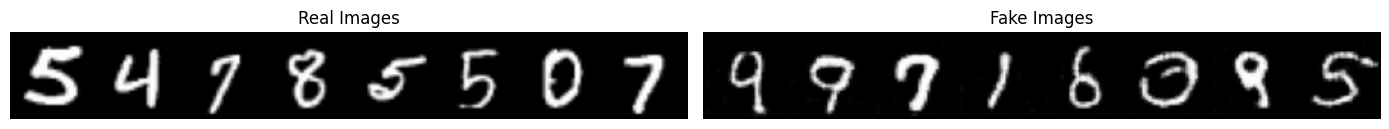

Epoch [0/5] Batch 100/469 Loss D: 0.2902, Loss G: 5.4626
Epoch [0/5] Batch 200/469 Loss D: 0.2701, Loss G: 4.3936
Epoch [0/5] Batch 300/469 Loss D: 0.1898, Loss G: 4.4998
Epoch [0/5] Batch 400/469 Loss D: 0.1433, Loss G: 2.6045
Epoch [1/5] Batch 0/469 Loss D: 0.1741, Loss G: 2.6471


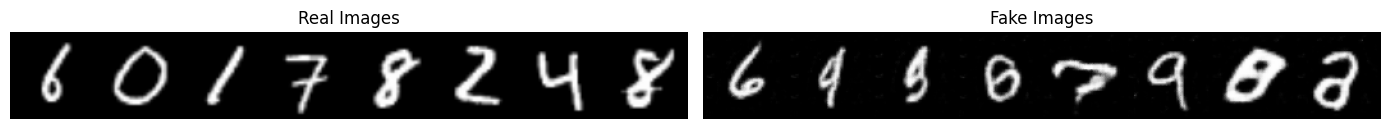

Epoch [1/5] Batch 100/469 Loss D: 0.0830, Loss G: 2.8180
Epoch [1/5] Batch 200/469 Loss D: 0.2740, Loss G: 2.5472
Epoch [1/5] Batch 300/469 Loss D: 0.2599, Loss G: 5.4587
Epoch [1/5] Batch 400/469 Loss D: 0.5474, Loss G: 3.4405
Epoch [2/5] Batch 0/469 Loss D: 0.2377, Loss G: 1.6654


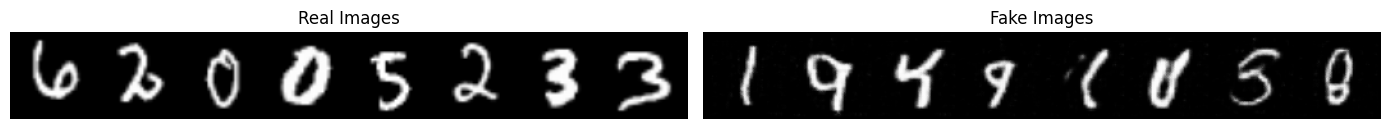

Epoch [2/5] Batch 100/469 Loss D: 0.0434, Loss G: 3.5105
Epoch [2/5] Batch 200/469 Loss D: 0.4592, Loss G: 0.9442
Epoch [2/5] Batch 300/469 Loss D: 0.7478, Loss G: 3.9612
Epoch [2/5] Batch 400/469 Loss D: 0.1027, Loss G: 1.9938
Epoch [3/5] Batch 0/469 Loss D: 0.1191, Loss G: 3.1746


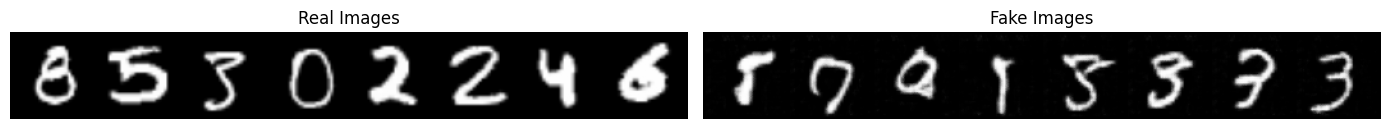

Epoch [3/5] Batch 100/469 Loss D: 0.1357, Loss G: 2.9567
Epoch [3/5] Batch 200/469 Loss D: 0.3236, Loss G: 1.7826
Epoch [3/5] Batch 300/469 Loss D: 0.1091, Loss G: 2.5125
Epoch [3/5] Batch 400/469 Loss D: 0.0751, Loss G: 3.4428
Epoch [4/5] Batch 0/469 Loss D: 0.1834, Loss G: 1.9059


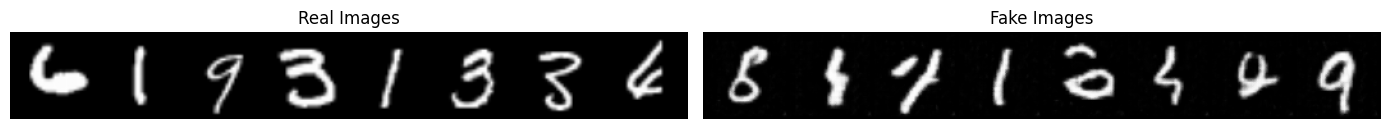

Epoch [4/5] Batch 100/469 Loss D: 0.6067, Loss G: 2.3456
Epoch [4/5] Batch 200/469 Loss D: 0.4354, Loss G: 1.6508
Epoch [4/5] Batch 300/469 Loss D: 0.2161, Loss G: 2.0402
Epoch [4/5] Batch 400/469 Loss D: 0.0794, Loss G: 4.2433


In [20]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.size(0)

        ### Generate fake images ###
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1, device=device)
        fake = gen(noise)

        ### Train Discriminator ###
        disc_real = disc(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach()).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator ###
        output = disc(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        ### Logging ###
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} "
                f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake_imgs = gen(fixed_noise)
                # Normalize back to [0, 1] for TensorBoard visualization
                fake_grid = torchvision.utils.make_grid(fake_imgs, normalize=True)
                real_grid = torchvision.utils.make_grid(real[:32], normalize=True)

                writer_fake.add_image("Fake Images", fake_grid, global_step=step)
                writer_real.add_image("Real Images", real_grid, global_step=step)

            step += 1

        if batch_idx == 0:  # Only for the first batch to avoid too many images
            plot_images(real, fake)
